## BT4222 Group Project, Group 9

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import f_classif, SelectPercentile

### Read in and clean raw data from different sources
The code for reading of data is referenced from the Kaggle source.

In [2]:
#Information on passenger activity for airports and airlines
passengers = pd.read_csv('T3_AIR_CARRIER_SUMMARY_AIRPORT_ACTIVITY_2019.csv')
passengers

,OP_UNIQUE_CARRIER,CARRIER_NAME,ORIGIN_AIRPORT_ID,SERVICE_CLASS,REV_ACRFT_DEP_PERF_510,REV_PAX_ENP_110
0,04Q,Tradewind Aviation,15024,K,10.0,39.0
1,04Q,Tradewind Aviation,14843,K,677.0,3649.0
2,04Q,Tradewind Aviation,10257,V,4.0,6.0
3,04Q,Tradewind Aviation,15323,V,1.0,3.0
4,04Q,Tradewind Aviation,10158,V,1.0,2.0
...,...,...,...,...,...,...
27247,ZW,Air Wisconsin Airlines Corp,11637,K,122.0,4535.0
27248,ZW,Air Wisconsin Airlines Corp,11721,K,143.0,5800.0
27249,ZW,Air Wisconsin Airlines Corp,10469,K,248.0,8901.0
27250,ZW,Air Wisconsin Airlines Corp,12884,K,187.0,7923.0


In [3]:
#Manufacture year and passenger capacity for aircraft by unique aircraft tail number
aircraft = pd.read_csv("B43_AIRCRAFT_INVENTORY.csv",encoding='latin1')
aircraft.drop_duplicates(subset='TAIL_NUM', inplace=True)
aircraft

,MANUFACTURE_YEAR,TAIL_NUM,NUMBER_OF_SEATS
0,1944,N54514,0.0
1,1945,N1651M,0.0
2,1953,N100CE,0.0
3,1953,N141FL,0.0
4,1953,N151FL,0.0
...,...,...,...
7378,2019,N14011,337.0
7379,2019,N16008,337.0
7380,2019,N16009,337.0
7381,2019,N2250U,276.0


In [4]:
#Coordinates of airports
coords = pd.read_csv('AIRPORT_COORDINATES.csv')
coords.drop_duplicates(subset='ORIGIN_AIRPORT_ID', inplace=True)
coords

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,10001,Afognak Lake Airport,58.109444,-152.906667
1,10003,Bear Creek Mining Strip,65.548056,-161.071667
2,10004,Lik Mining Camp,68.083333,-163.166667
3,10005,Little Squaw Airport,67.570000,-148.183889
4,10006,Kizhuyak Bay,57.745278,-152.882778
...,...,...,...,...
18128,16908,Deer Park Airport,47.966944,-117.428611
18129,16909,South Texas International at Edinburg,26.441667,-98.122222
18130,16910,Louisa County Freeman Field,38.009722,-77.970000
18131,16911,Caldwell Industrial,43.641944,-116.635833


In [5]:
#Proper names of carriers for better EDA usage
names = pd.read_csv("CARRIER_DECODE.csv")
names.drop_duplicates(inplace=True)
names.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)
names

,AIRLINE_ID,OP_UNIQUE_CARRIER,CARRIER_NAME
0,21754,2PQ,21 Air LLC
3,20342,Q5,40-Mile Air
4,20342,WRB,40-Mile Air
6,19627,CIQ,A/S Conair
7,19072,AAE,AAA Airlines
...,...,...,...
2702,20379,ZKQ,Zantop International
2706,19771,ZAQ,Zas Airline Of Egypt
2707,21118,37,Zeal 320
2708,22069,ZG,ZIPAIR Tokyo Inc.


In [6]:
#Weather report for top 90% of airport cities, in 2019
weather_report = pd.read_csv('airport_weather_2019.csv')
weather_report

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT08,WT09,WESD,WT10,PSUN,TSUN,SN32,SX32,TOBS,WT11
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/1/2019,4.70,NaN,0.14,0.0,0.0,64.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/2/2019,4.92,NaN,0.57,0.0,0.0,56.0,59.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/3/2019,5.37,NaN,0.15,0.0,0.0,52.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/4/2019,12.08,NaN,1.44,0.0,0.0,56.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/5/2019,13.42,NaN,0.00,0.0,0.0,49.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38670,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-27,6.04,NaN,0.00,NaN,NaN,68.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38671,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-28,5.37,NaN,0.06,NaN,NaN,69.0,74.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38672,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-29,7.61,NaN,0.10,NaN,NaN,70.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38673,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-30,5.82,NaN,0.02,NaN,NaN,68.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Our list of cities and airports including the airport display name so that we can connect with our main df
cities = pd.read_csv('airports_list.csv')
cities

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"
1,10257,Albany International,"Albany, NY","ALBANY INTERNATIONAL AIRPORT, NY US"
2,10140,Albuquerque International Sunport,"Albuquerque, NM","ALBUQUERQUE INTERNATIONAL AIRPORT, NM US"
3,10299,Anchorage International,"Anchorage, AK","ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A..."
4,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
...,...,...,...,...
92,15370,Tulsa International,"Tulsa, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
93,12264,Washington Dulles International,"Washington, DC","WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US"
94,13851,Will Rogers World,"Oklahoma City, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
95,12191,William P Hobby,"Houston, TX","HOUSTON WILLIAM P HOBBY AIRPORT, TX US"


In [8]:
#Connect weather report with city names
weather_merge = pd.merge(cities, weather_report, how='left', on='NAME')
weather_merge.columns

Index(['ORIGIN_AIRPORT_ID', 'DISPLAY_AIRPORT_NAME', 'ORIGIN_CITY_NAME', 'NAME',
       'STATION', 'DATE', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03',
       'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WESD', 'WT10', 'PSUN',
       'TSUN', 'SN32', 'SX32', 'TOBS', 'WT11'],
      dtype='object')

In [9]:
#Get only important metrics from the weather report (date, inches of precipitation, inches of snowfall, average temperature, average wind)
weather = weather_merge[['DATE', 'PRCP', 'SNOW', 'TAVG', 'AWND', 'ORIGIN_AIRPORT_ID']]

In [10]:
#Drop rows where no departure airport was recorded
weather.drop(weather.loc[weather['ORIGIN_AIRPORT_ID'].isna()].index, axis=0, inplace=True)

In [11]:
#Drop rows where no weather was recorded
weather.dropna(inplace=True)
weather

,DATE,PRCP,SNOW,TAVG,AWND,ORIGIN_AIRPORT_ID
365,2019-01-01,0.10,0.0,42.0,15.21,10257
366,2019-01-02,0.00,0.0,28.0,3.80,10257
367,2019-01-03,0.00,0.1,35.0,9.62,10257
368,2019-01-04,0.00,0.0,36.0,6.93,10257
369,2019-01-05,0.42,0.0,36.0,4.70,10257
...,...,...,...,...,...,...
35020,2019-12-27,0.00,0.0,32.0,5.82,10713
35021,2019-12-28,0.00,0.0,29.0,2.24,10713
35022,2019-12-29,0.04,0.1,31.0,6.26,10713
35023,2019-12-30,0.00,0.0,31.0,2.46,10713


In [12]:
#Cast data types to datetime to access the month and day of month to match up with main df
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['MONTH'] = pd.DatetimeIndex(weather['DATE']).month
weather['DAY_OF_MONTH'] = pd.DatetimeIndex(weather['DATE']).day
weather

,DATE,PRCP,SNOW,TAVG,AWND,ORIGIN_AIRPORT_ID,MONTH,DAY_OF_MONTH
365,2019-01-01,0.10,0.0,42.0,15.21,10257,1,1
366,2019-01-02,0.00,0.0,28.0,3.80,10257,1,2
367,2019-01-03,0.00,0.1,35.0,9.62,10257,1,3
368,2019-01-04,0.00,0.0,36.0,6.93,10257,1,4
369,2019-01-05,0.42,0.0,36.0,4.70,10257,1,5
...,...,...,...,...,...,...,...,...
35020,2019-12-27,0.00,0.0,32.0,5.82,10713,12,27
35021,2019-12-28,0.00,0.0,29.0,2.24,10713,12,28
35022,2019-12-29,0.04,0.1,31.0,6.26,10713,12,29
35023,2019-12-30,0.00,0.0,31.0,2.46,10713,12,30


In [13]:
def month_cleanup(monthly_data, aircraft, coords, names, weather):

    # drop rows with no departure time, tail number, or were cancelled
    monthly_data.drop(monthly_data.loc[monthly_data['DEP_TIME'].isna()].index, axis=0, inplace=True)
    monthly_data.drop(monthly_data.loc[monthly_data['TAIL_NUM'].isna()].index, axis=0, inplace=True)
    monthly_data.drop(monthly_data.loc[monthly_data['CANCELLED'].isna()].index, axis=0, inplace=True)
 
    # FEATURE ENGINEERING - SEGMENT NUMBER
    # list flight segment number for daily flight segments by tracking tail number
    monthly_data["SEGMENT_NUMBER"] = monthly_data.groupby(["TAIL_NUM", 'DAY_OF_MONTH'])["DEP_TIME"].rank("dense", ascending=True)
    
    # FEATURE ENGINEERING - CONCURRENT FLIGHTS
    # listing the number of concurrent flights at the airport in the time block 
    monthly_data['CONCURRENT_FLIGHTS'] = monthly_data.groupby(['ORIGIN_AIRPORT_ID','DAY_OF_MONTH', 'DEP_TIME_BLK'])['OP_UNIQUE_CARRIER'].transform("count")
 
    # MERGING to get NUMBER_OF_SEATS
    # merge aircraft info with main frame on tail number - get NUMBER_OF_SEATS 
    monthly_data = pd.merge(monthly_data, aircraft, how="left", on='TAIL_NUM')
    monthly_data['NUMBER_OF_SEATS'].dropna(inplace=True)

    # merge to get proper carrier name 
    monthly_data = pd.merge(monthly_data, names, how='left', on=['OP_UNIQUE_CARRIER'])

    # FEATURE ENGINEERING - AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH
    # Add monthly flight statistics for carrier and airport
    monthly_data['AIRPORT_FLIGHTS_MONTH'] = monthly_data.groupby(['ORIGIN_AIRPORT_ID'])['ORIGIN_CITY_NAME'].transform('count')
    monthly_data['AIRLINE_FLIGHTS_MONTH'] = monthly_data.groupby(['OP_UNIQUE_CARRIER'])['ORIGIN_CITY_NAME'].transform('count')
    monthly_data['AIRLINE_AIRPORT_FLIGHTS_MONTH'] = monthly_data.groupby(['OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID'])['ORIGIN_CITY_NAME'].transform('count')
    
    # FEATURE ENGINEERING - AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE
    #Add monthly passenger statistics for carrier and airport
    monthly_airport_passengers = pd.DataFrame(passengers.groupby(['ORIGIN_AIRPORT_ID'])['REV_PAX_ENP_110'].sum())
    monthly_data = pd.merge(monthly_data, monthly_airport_passengers, how='left', on=['ORIGIN_AIRPORT_ID'])
    monthly_data['AVG_MONTHLY_PASS_AIRPORT'] = (monthly_data['REV_PAX_ENP_110']/12).astype('int64')
    monthly_airline_passengers = pd.DataFrame(passengers.groupby(['OP_UNIQUE_CARRIER'])['REV_PAX_ENP_110'].sum())
    monthly_data = pd.merge(monthly_data, monthly_airline_passengers, how='left', on=['OP_UNIQUE_CARRIER'])
    monthly_data['AVG_MONTHLY_PASS_AIRLINE'] = (monthly_data['REV_PAX_ENP_110_y']/12).astype('int64')
    
    # FEATURE ENGINEERING - PLANE AGE
    # calculate age of plane
    monthly_data['MANUFACTURE_YEAR'].dropna(inplace=True)
    monthly_data['PLANE_AGE'] = 2019 - monthly_data['MANUFACTURE_YEAR']

    # merge to get airport coordinates
    monthly_data = pd.merge(monthly_data, coords, how='left', on=['ORIGIN_AIRPORT_ID'])
    monthly_data['LATITUDE'] = round(monthly_data['LATITUDE'], 3)
    monthly_data['LONGITUDE'] = round(monthly_data['LONGITUDE'], 3)

    # FEATURE ENGINEERING - PREVIOUS AIRPORT
    # get previous airport for tail number
    segment_temp = monthly_data[['DAY_OF_MONTH', 'TAIL_NUM', 'DISPLAY_AIRPORT_NAME', 'SEGMENT_NUMBER']]
    monthly_data = pd.merge_asof(monthly_data.sort_values('SEGMENT_NUMBER'), segment_temp.sort_values('SEGMENT_NUMBER'), on='SEGMENT_NUMBER', by=['DAY_OF_MONTH', 'TAIL_NUM'], allow_exact_matches=False)
    monthly_data['DISPLAY_AIRPORT_NAME_y'].fillna('NONE', inplace=True)
    monthly_data.rename(columns={"DISPLAY_AIRPORT_NAME_y": "PREVIOUS_AIRPORT", "DISPLAY_AIRPORT_NAME_x": "DEPARTING_AIRPORT"}, inplace=True)  
    
    # drop airports below the 10th percentile
    monthly_data.drop(monthly_data.loc[monthly_data['AIRPORT_FLIGHTS_MONTH'] < 1100].index, axis=0, inplace=True)

    # merge weather data
    monthly_data = pd.merge(monthly_data, weather, how='inner', on=['ORIGIN_AIRPORT_ID', 'MONTH', 'DAY_OF_MONTH'])

    # drop columns we won't use, 
    monthly_data.drop(columns = ['ORIGIN',  'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
                                 'ARR_TIME', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME',
                                 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
                                 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ARR_DELAY_NEW',
                                 'Unnamed: 32', 'ARR_TIME_BLK', 'ACTUAL_ELAPSED_TIME',
                                 'DEST_AIRPORT_ID', 'DEST_CITY_NAME',  'OP_CARRIER_FL_NUM',
                                 'OP_UNIQUE_CARRIER', 'AIRLINE_ID', 'DATE', 'DAY_OF_MONTH',
                                 'TAIL_NUM','DEP_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME',
                                 'MANUFACTURE_YEAR'
                                 ],
                    axis=1, inplace=True)
    
    monthly_data['MONTH'] = monthly_data['MONTH'].astype('object')
    monthly_data['DAY_OF_WEEK'] = monthly_data['DAY_OF_WEEK'].astype('object')
    monthly_data['DISTANCE'] = monthly_data['DISTANCE'].astype('int64')
    monthly_data['SEGMENT_NUMBER'] = monthly_data['SEGMENT_NUMBER'].astype('int8')
    monthly_data['AIRPORT_FLIGHTS_MONTH'] = monthly_data['AIRPORT_FLIGHTS_MONTH'].astype('int64')
    
    monthly_data.reset_index(inplace=True, drop=True)
    
    return monthly_data

### All code from here on is not referenced from the Kaggle source.

In [14]:
#Processing all files
files = ['ONTIME_REPORTING_01.csv', 'ONTIME_REPORTING_02.csv', 'ONTIME_REPORTING_03.csv',
         'ONTIME_REPORTING_04.csv', 'ONTIME_REPORTING_05.csv', 'ONTIME_REPORTING_06.csv',
         'ONTIME_REPORTING_07.csv', 'ONTIME_REPORTING_08.csv', 'ONTIME_REPORTING_09.csv',
         'ONTIME_REPORTING_10.csv', 'ONTIME_REPORTING_11.csv', 'ONTIME_REPORTING_12.csv']

month_df_list = []

for file in files:
    df = pd.read_csv(file)
    curr_month = month_cleanup(df, aircraft, coords, names, weather)
    month_df_list.append(curr_month)
    print("Processing done for file", file)

Processing done for file ONTIME_REPORTING_01.csv
Processing done for file ONTIME_REPORTING_02.csv
Processing done for file ONTIME_REPORTING_03.csv
Processing done for file ONTIME_REPORTING_04.csv
Processing done for file ONTIME_REPORTING_05.csv
Processing done for file ONTIME_REPORTING_06.csv
Processing done for file ONTIME_REPORTING_07.csv
Processing done for file ONTIME_REPORTING_08.csv
Processing done for file ONTIME_REPORTING_09.csv
Processing done for file ONTIME_REPORTING_10.csv
Processing done for file ONTIME_REPORTING_11.csv
Processing done for file ONTIME_REPORTING_12.csv


In [15]:
#Combine all processed raw data to form the main df
combined_df = pd.DataFrame()
for df in month_df_list:
    combined_df = pd.concat([combined_df, df], axis=0)

### Re-assigning values in variables to our newly defined values

The new values are more meaningful and will help to avoid having too many unecessary values in each variable.

In [16]:
#Re-assign seasons
seasons = []
month = combined_df["MONTH"].to_list()

for num in range(len(combined_df.index)):
    if month[num] in [3, 4, 5]:
        seasons.append("Spring")
    elif month[num] in [6, 7, 8]:
        seasons.append("Summer")
    elif month[num] in [9, 10, 11]:
        seasons.append("Autumn")
    else:
        seasons.append("Winter")

combined_df["SEASON"] = seasons

In [17]:
#Re-assign time of week
time_of_week = []
day = combined_df["DAY_OF_WEEK"].to_list()

for num in range(len(combined_df.index)):
    if day[num] in [1, 2]:
        time_of_week.append("Start")
    elif day[num] in [3, 4]:
        time_of_week.append("Mid")
    else:
        time_of_week.append("Weekend")

combined_df["TIME_OF_WEEK"] = time_of_week 

In [18]:
#Re-assign time of day
combined_df["DEP_TIME_BLK"].unique()

early_morning = ["0001-0559"]
morning = ["0600-0659", "0700-0759", "0800-0859",
           "0900-0959", "1000-1059", "1100-1159"]
afternoon = ["1200-1259", "1300-1359", "1400-1459",
             "1500-1559", "1600-1659", "1700-1759"]
night = ["1800-1859", "1900-1959", "2000-2059",
         "2100-2159", "2200-2259", "2300-2359"]

time_of_day = []
block = combined_df["DEP_TIME_BLK"].to_list()

for num in range(len(combined_df.index)):
    if block[num] in early_morning:
        time_of_day.append("Early Morning")
    elif block[num] in morning:
        time_of_day.append("Morning")
    elif block[num] in afternoon:
        time_of_day.append("Afternoon")
    else:
        time_of_day.append("Night")

combined_df["TIME_OF_DAY"] = time_of_day

In [19]:
combined_df.columns

Index(['MONTH', 'DAY_OF_WEEK', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK',
       'CANCELLED', 'DISTANCE', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS',
       'NUMBER_OF_SEATS', 'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH',
       'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH',
       'REV_PAX_ENP_110_x', 'AVG_MONTHLY_PASS_AIRPORT', 'REV_PAX_ENP_110_y',
       'AVG_MONTHLY_PASS_AIRLINE', 'PLANE_AGE', 'DEPARTING_AIRPORT',
       'LATITUDE', 'LONGITUDE', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'TAVG',
       'AWND', 'SEASON', 'TIME_OF_WEEK', 'TIME_OF_DAY'],
      dtype='object')

In [20]:
#Drop unused columns
combined_df.drop(["MONTH", "DAY_OF_WEEK", "DEP_DELAY_NEW", "DEP_TIME_BLK", "CANCELLED", 
                  "SEGMENT_NUMBER", "AIRPORT_FLIGHTS_MONTH", "LATITUDE", "LONGITUDE", "PREVIOUS_AIRPORT",
                  "CARRIER_NAME", "AIRLINE_FLIGHTS_MONTH", "AIRLINE_AIRPORT_FLIGHTS_MONTH", "REV_PAX_ENP_110_x",
                  "REV_PAX_ENP_110_y", "DEPARTING_AIRPORT"], axis=1, inplace=True)

In [21]:
#Drop rows with missing data
combined_df.dropna(inplace=True)

In [22]:
combined_df

,DEP_DEL15,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY
0,1.0,719,18,173.0,3103410,8501631,5.0,0.53,5.0,18.0,12.75,Winter,Start,Night
2,1.0,1514,35,216.0,3103410,8501631,16.0,0.53,5.0,18.0,12.75,Winter,Start,Morning
3,1.0,888,36,216.0,3103410,8501631,15.0,0.53,5.0,18.0,12.75,Winter,Start,Morning
4,1.0,2072,35,173.0,3103410,8501631,6.0,0.53,5.0,18.0,12.75,Winter,Start,Morning
5,0.0,1846,23,173.0,3103410,8501631,6.0,0.53,5.0,18.0,12.75,Winter,Start,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342049,1.0,1444,9,143.0,819756,13382999,14.0,0.00,0.0,33.0,9.40,Winter,Weekend,Night
342050,1.0,990,11,143.0,819756,13382999,18.0,0.00,0.0,33.0,9.40,Winter,Weekend,Afternoon
342051,0.0,825,16,143.0,819756,13382999,19.0,0.00,0.0,33.0,9.40,Winter,Weekend,Night
342052,1.0,349,5,143.0,819756,13382999,19.0,0.00,0.0,33.0,9.40,Winter,Weekend,Night


### Exploratory Data Analysis

In [23]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4005685 entries, 0 to 342053
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   DEP_DEL15                 float64
 1   DISTANCE                  int64  
 2   CONCURRENT_FLIGHTS        int64  
 3   NUMBER_OF_SEATS           float64
 4   AVG_MONTHLY_PASS_AIRPORT  int64  
 5   AVG_MONTHLY_PASS_AIRLINE  int64  
 6   PLANE_AGE                 float64
 7   PRCP                      float64
 8   SNOW                      float64
 9   TAVG                      float64
 10  AWND                      float64
 11  SEASON                    object 
 12  TIME_OF_WEEK              object 
 13  TIME_OF_DAY               object 
dtypes: float64(7), int64(4), object(3)
memory usage: 458.4+ MB


In [24]:
combined_df.isnull().sum() 

DEP_DEL15                   0
DISTANCE                    0
CONCURRENT_FLIGHTS          0
NUMBER_OF_SEATS             0
AVG_MONTHLY_PASS_AIRPORT    0
AVG_MONTHLY_PASS_AIRLINE    0
PLANE_AGE                   0
PRCP                        0
SNOW                        0
TAVG                        0
AWND                        0
SEASON                      0
TIME_OF_WEEK                0
TIME_OF_DAY                 0
dtype: int64

In [25]:
combined_df['DEP_DEL15'].value_counts()

0.0    3244205
1.0     761480
Name: DEP_DEL15, dtype: int64

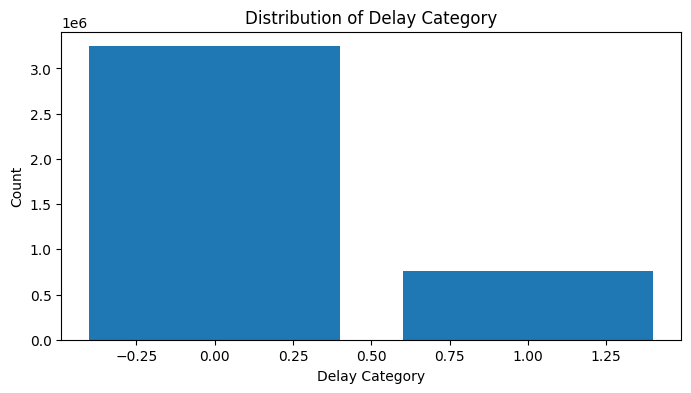

In [26]:
plt.figure(figsize=(8,4))
plt.bar(combined_df['DEP_DEL15'].value_counts().index, combined_df['DEP_DEL15'].value_counts().values)
plt.xlabel('Delay Category')
plt.ylabel('Count')
plt.title('Distribution of Delay Category')
plt.show()

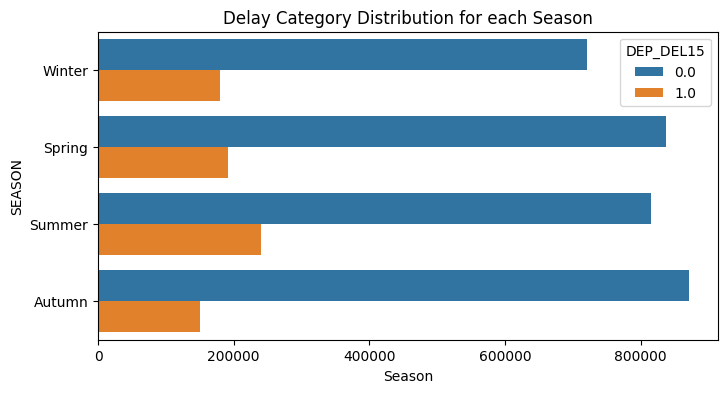

In [27]:
plt.figure(figsize=(8,4))
sns.countplot(y=combined_df['SEASON'], hue=combined_df['DEP_DEL15'])
plt.title('Delay Category Distribution for each Season')
plt.xlabel('Season')
plt.show()

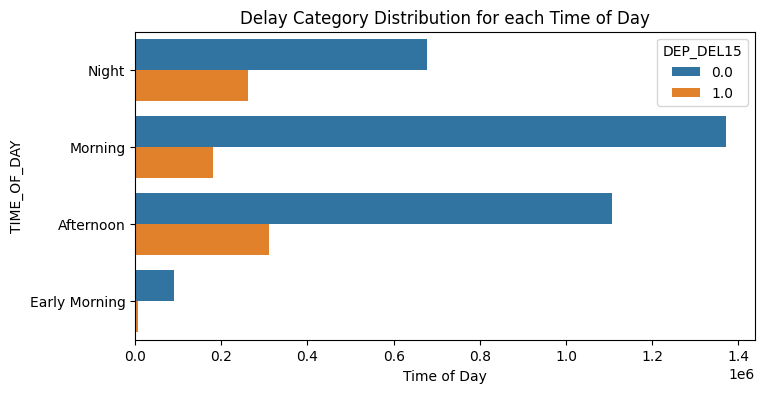

In [28]:
plt.figure(figsize=(8,4))
sns.countplot(y=combined_df['TIME_OF_DAY'], hue=combined_df['DEP_DEL15'])
plt.title('Delay Category Distribution for each Time of Day')
plt.xlabel('Time of Day')
plt.show()

### Undersampling
Undersample to balance the categories in the target variable. Since the original dataset has over 4 million rows, undersampling was chosen over oversampling.

In [29]:
#Create individual dataframes for each category of the target variable
unique_cat = np.sort(combined_df['DEP_DEL15'].unique()) 
df_list = [] # index position corresponds to the target variable label

for cat in unique_cat:
    df = pd.DataFrame(combined_df.loc[combined_df['DEP_DEL15'] == cat])
    df_list.append(df)

In [30]:
#Python's random library is used to randomly undersample the data
new_df_list = []

i = 0
for df in df_list:
    curr_list = []

    df_length = len(df.index)
    deck = list(range(df_length))
    
    random.shuffle(deck)
    for num in range(40000):
        curr_list.append(deck.pop())

    new_df = pd.DataFrame()
    for idx in curr_list:
        new_df = pd.concat([new_df, df.iloc[[idx]]], axis=0)
    new_df_list.append(new_df)
    i += 1

In [31]:
#Join all the undersampled df together
combined_final_df = pd.DataFrame()

for new_df in new_df_list:
    combined_final_df = pd.concat([combined_final_df, new_df], axis=0)

combined_final_df

,DEP_DEL15,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY
330512,0.0,649,4,76.0,171473,3472966,5.0,0.00,0.0,78.0,8.05,Summer,Start,Morning
98424,0.0,854,4,173.0,1823051,8501631,7.0,0.95,0.0,78.0,6.71,Summer,Start,Early Morning
176198,0.0,1124,22,191.0,1472200,12460183,1.0,0.00,0.0,73.0,8.72,Summer,Mid,Morning
248037,0.0,674,5,76.0,171473,3472966,5.0,0.00,0.0,40.0,3.80,Autumn,Mid,Morning
28473,0.0,765,86,76.0,4365661,1212846,5.0,0.00,0.0,71.0,11.86,Summer,Mid,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109726,1.0,280,10,160.0,1297685,11744595,8.0,0.15,0.0,38.0,13.87,Winter,Start,Morning
233415,1.0,925,69,154.0,3103410,8501631,14.0,0.00,0.0,71.0,7.83,Autumn,Start,Afternoon
75212,1.0,197,12,143.0,874468,13382999,20.0,0.00,0.0,66.0,4.47,Winter,Start,Night
327952,1.0,1750,12,143.0,819756,13382999,14.0,0.03,0.0,65.0,8.28,Autumn,Weekend,Night


### Check distribution of variables before and after undersampling 
This is to ensure all patterns in the data are retained after undersampling, to minimise infomation loss.

In [32]:
combined_df.describe()

,DEP_DEL15,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE,PRCP,SNOW,TAVG,AWND
count,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06,4.005685e+06
mean,1.900998e-01,8.131408e+02,2.962048e+01,1.321477e+02,1.677930e+06,7.846512e+06,1.165171e+01,1.090403e-01,4.779717e-02,5.892055e+01,8.447346e+00
std,3.923798e-01,5.717903e+02,2.203241e+01,4.717560e+01,1.195570e+06,5.016189e+06,7.127760e+00,3.025686e-01,3.842236e-01,1.818922e+01,3.642846e+00
min,0.000000e+00,6.700000e+01,1.000000e+00,4.400000e+01,8.973300e+04,4.737940e+05,0.000000e+00,0.000000e+00,0.000000e+00,-1.500000e+01,0.000000e+00
25%,0.000000e+00,4.040000e+02,1.200000e+01,7.600000e+01,7.803260e+05,2.688839e+06,5.000000e+00,0.000000e+00,0.000000e+00,4.500000e+01,5.820000e+00
50%,0.000000e+00,6.660000e+02,2.400000e+01,1.430000e+02,1.486066e+06,8.501631e+06,1.200000e+01,0.000000e+00,0.000000e+00,6.100000e+01,7.830000e+00
75%,0.000000e+00,1.024000e+03,4.300000e+01,1.730000e+02,2.006675e+06,1.246018e+07,1.700000e+01,4.000000e-02,0.000000e+00,7.400000e+01,1.051000e+01
max,1.000000e+00,5.095000e+03,1.090000e+02,3.370000e+02,4.365661e+06,1.338300e+07,3.200000e+01,5.080000e+00,9.900000e+00,1.010000e+02,3.378000e+01


In [33]:
combined_final_df.describe()

,DEP_DEL15,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE,PRCP,SNOW,TAVG,AWND
count,80000.000000,80000.00000,80000.000000,80000.000000,8.000000e+04,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.500000,818.53880,29.784437,132.488275,1.704803e+06,7.841700e+06,11.731813,0.133887,0.068808,59.035600,8.586188
std,0.500003,572.48853,21.884672,47.252014,1.184982e+06,5.015068e+06,7.059305,0.343712,0.489139,18.597439,3.713297
min,0.000000,67.00000,1.000000,44.000000,8.973300e+04,4.737940e+05,0.000000,0.000000,0.000000,-15.000000,0.000000
25%,0.000000,405.00000,13.000000,76.000000,8.003020e+05,2.884187e+06,5.000000,0.000000,0.000000,44.000000,5.820000
50%,0.500000,675.00000,24.000000,143.000000,1.486066e+06,8.501631e+06,13.000000,0.000000,0.000000,62.000000,8.050000
75%,1.000000,1029.00000,43.000000,173.000000,2.006675e+06,1.246018e+07,17.000000,0.080000,0.000000,75.000000,10.510000
max,1.000000,5095.00000,109.000000,337.000000,4.365661e+06,1.338300e+07,32.000000,4.770000,9.900000,101.000000,33.780000


### Normalizing numerical variables
The different numerical variables have different ranges, thus we normalize to prevent the learning rate of models from being largely determined by the feature with the largest range.

In [34]:
def normalize(x, max, min):
    return (x-min) / (max-min)

numeric_cols = ['DISTANCE', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'AVG_MONTHLY_PASS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE', 'PLANE_AGE', 'PRCP', 'SNOW', 'TAVG', 'AWND']
for col in numeric_cols:
    max, min = np.max(combined_final_df[col]), np.min(combined_final_df[col])
    new_values = []
    for val in combined_final_df[col]:
        new_values.append((val - min) / (max - min))
    combined_final_df[col] = new_values

combined_final_df

,DEP_DEL15,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY
330512,0.0,0.115752,0.027778,0.109215,0.019116,0.232328,0.15625,0.000000,0.0,0.801724,0.238307,Summer,Start,Morning
98424,0.0,0.156523,0.027778,0.440273,0.405367,0.621869,0.21875,0.199161,0.0,0.801724,0.198638,Summer,Start,Early Morning
176198,0.0,0.210223,0.194444,0.501706,0.323314,0.928515,0.03125,0.000000,0.0,0.758621,0.258141,Summer,Mid,Morning
248037,0.0,0.120724,0.037037,0.109215,0.019116,0.232328,0.15625,0.000000,0.0,0.474138,0.112493,Autumn,Mid,Morning
28473,0.0,0.138823,0.787037,0.109215,1.000000,0.057250,0.15625,0.000000,0.0,0.741379,0.351095,Summer,Mid,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109726,1.0,0.042363,0.083333,0.395904,0.282501,0.873083,0.25000,0.031447,0.0,0.456897,0.410598,Winter,Start,Morning
233415,1.0,0.170644,0.629630,0.375427,0.704801,0.621869,0.43750,0.000000,0.0,0.741379,0.231794,Autumn,Start,Afternoon
75212,1.0,0.025855,0.101852,0.337884,0.183524,1.000000,0.62500,0.000000,0.0,0.698276,0.132327,Winter,Start,Night
327952,1.0,0.334726,0.101852,0.337884,0.170729,1.000000,0.43750,0.006289,0.0,0.689655,0.245115,Autumn,Weekend,Night


### Label Encoding

In [35]:
# label encoding
label_enc = preprocessing.LabelEncoder()
cols = ["SEASON", "TIME_OF_WEEK", "TIME_OF_DAY"]
new_col_names = []

new_test_df = pd.DataFrame()
for col in cols:
    new_col = label_enc.fit_transform(combined_final_df[col])

    for name in label_enc.classes_:
        new_col_names.append(name)
    
    combined_final_df[col] = new_col

In [36]:
combined_final_df

,DEP_DEL15,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY
330512,0.0,0.115752,0.027778,0.109215,0.019116,0.232328,0.15625,0.000000,0.0,0.801724,0.238307,2,1,2
98424,0.0,0.156523,0.027778,0.440273,0.405367,0.621869,0.21875,0.199161,0.0,0.801724,0.198638,2,1,1
176198,0.0,0.210223,0.194444,0.501706,0.323314,0.928515,0.03125,0.000000,0.0,0.758621,0.258141,2,0,2
248037,0.0,0.120724,0.037037,0.109215,0.019116,0.232328,0.15625,0.000000,0.0,0.474138,0.112493,0,0,2
28473,0.0,0.138823,0.787037,0.109215,1.000000,0.057250,0.15625,0.000000,0.0,0.741379,0.351095,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109726,1.0,0.042363,0.083333,0.395904,0.282501,0.873083,0.25000,0.031447,0.0,0.456897,0.410598,3,1,2
233415,1.0,0.170644,0.629630,0.375427,0.704801,0.621869,0.43750,0.000000,0.0,0.741379,0.231794,0,1,0
75212,1.0,0.025855,0.101852,0.337884,0.183524,1.000000,0.62500,0.000000,0.0,0.698276,0.132327,3,1,3
327952,1.0,0.334726,0.101852,0.337884,0.170729,1.000000,0.43750,0.006289,0.0,0.689655,0.245115,0,2,3


### Splitting Dataset

In [37]:
#Split into train, test, validation sets
x = combined_final_df.drop(columns=['DEP_DEL15'], axis=1)
y = combined_final_df['DEP_DEL15']
X_train, X_left, y_train, y_left = train_test_split(x, y, train_size=0.7, random_state=105)
X_valid, X_test, y_valid, y_test = train_test_split(X_left,y_left, test_size=0.5, random_state=105)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(56000, 13)
(12000, 13)
(12000, 13)


### Feature Selection

Categorical Feature Selection

In [38]:
cont_labels = ["DISTANCE", "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS", "AVG_MONTHLY_PASS_AIRPORT", "AVG_MONTHLY_PASS_AIRLINE", "PLANE_AGE", "PRCP", "SNOW", "TAVG", "AWND"]
cat_labels = ["SEASON", "TIME_OF_WEEK", "TIME_OF_DAY"]

cont_features_df = X_train[cont_labels]
cat_features_df = X_train[cat_labels]

In [39]:
mi_score = MIC(cat_features_df, y_train)

In [40]:
mi_score = pd.Series(mi_score)
mi_score.index = cat_features_df.columns
mi_score.sort_values(ascending=False)
mi_score

SEASON          0.009090
TIME_OF_WEEK    0.003228
TIME_OF_DAY     0.029255
dtype: float64

Since mutual information score for TIME_OF_DAY is the highest, only this feature is retained.

In [41]:
selected_cat_var = ["TIME_OF_DAY"]

Continuous Feature Selection

In [42]:
cont_features_df['DEP_DEL15'] = y_train
corr_mat = cont_features_df.corr(method='kendall')
corr_mat['DEP_DEL15'][:-1]

DISTANCE                    0.016402
CONCURRENT_FLIGHTS          0.003621
NUMBER_OF_SEATS             0.005187
AVG_MONTHLY_PASS_AIRPORT    0.030660
AVG_MONTHLY_PASS_AIRLINE    0.004603
PLANE_AGE                   0.008815
PRCP                        0.119528
SNOW                        0.075027
TAVG                        0.010505
AWND                        0.045500
Name: DEP_DEL15, dtype: float64

In [43]:
new_corr = abs(corr_mat['DEP_DEL15'][:-1]).sort_values(ascending=False)
new_corr

PRCP                        0.119528
SNOW                        0.075027
AWND                        0.045500
AVG_MONTHLY_PASS_AIRPORT    0.030660
DISTANCE                    0.016402
TAVG                        0.010505
PLANE_AGE                   0.008815
NUMBER_OF_SEATS             0.005187
AVG_MONTHLY_PASS_AIRLINE    0.004603
CONCURRENT_FLIGHTS          0.003621
Name: DEP_DEL15, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

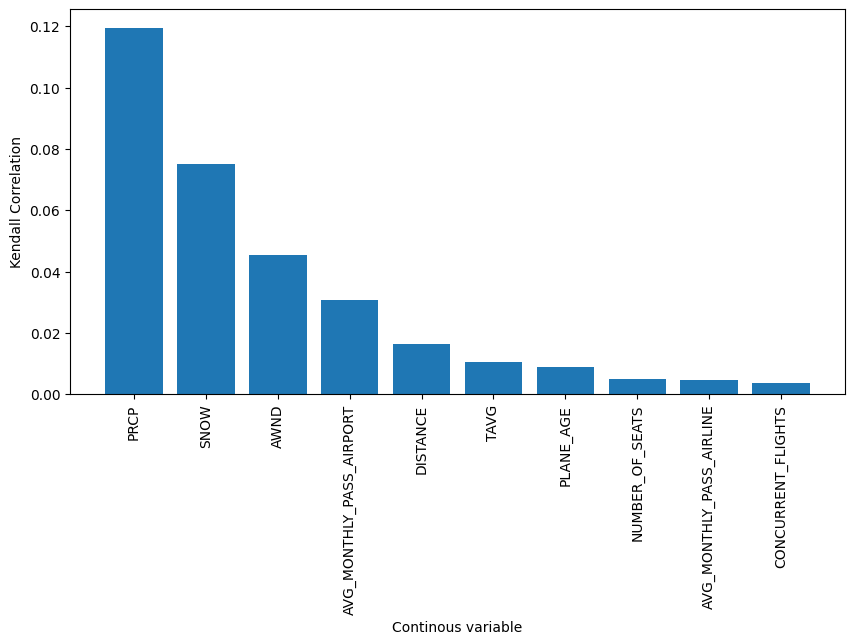

In [44]:
plt.figure(figsize=(10,5))
plt.bar(new_corr.index, new_corr.values)
plt.xlabel('Continous variable')
plt.ylabel('Kendall Correlation')
plt.xticks(rotation=90)

Select top 5 continuous features according to Kendall method

In [45]:
selected_numeric_var = list(new_corr[:5].index)
selected_numeric_var

['PRCP', 'SNOW', 'AWND', 'AVG_MONTHLY_PASS_AIRPORT', 'DISTANCE']

In [46]:
# Selecting chosen features from combined_final_df
final_cols = selected_numeric_var + selected_cat_var

final_train_df = X_train[final_cols]
final_valid_df = X_valid[final_cols]
final_test_df = X_test[final_cols]

final_train_df["DEP_DEL15"] = y_train
final_valid_df["DEP_DEL15"] = y_valid
final_test_df["DEP_DEL15"] = y_test

In [47]:
final_train_df.to_csv("processed_train_set.csv", index=False)
final_valid_df.to_csv("processed_valid_set.csv", index=False)
final_test_df.to_csv("processed_test_set.csv", index=False)

In [2]:
train_df = pd.read_csv("./processed_train_set.csv")
train_df

,PRCP,SNOW,AWND,AVG_MONTHLY_PASS_AIRPORT,DISTANCE,TIME_OF_DAY,DEP_DEL15
0,0.008386,0.0,0.245115,0.620588,0.085123,0,1.0
1,0.002096,0.0,0.456779,1.000000,0.239061,2,0.0
2,0.010482,0.0,0.225281,0.437569,0.012331,3,0.0
3,0.037736,0.0,0.278271,0.704801,0.287788,0,0.0
4,0.039832,0.0,0.211960,0.378600,0.184964,0,1.0
...,...,...,...,...,...,...,...
55995,0.000000,0.0,0.251628,1.000000,0.132060,2,0.0
55996,0.000000,0.0,0.483422,0.013036,0.241647,2,1.0
55997,0.000000,0.0,0.337774,0.620588,0.283214,2,1.0
55998,0.027254,0.0,0.145648,0.234743,0.044153,2,1.0


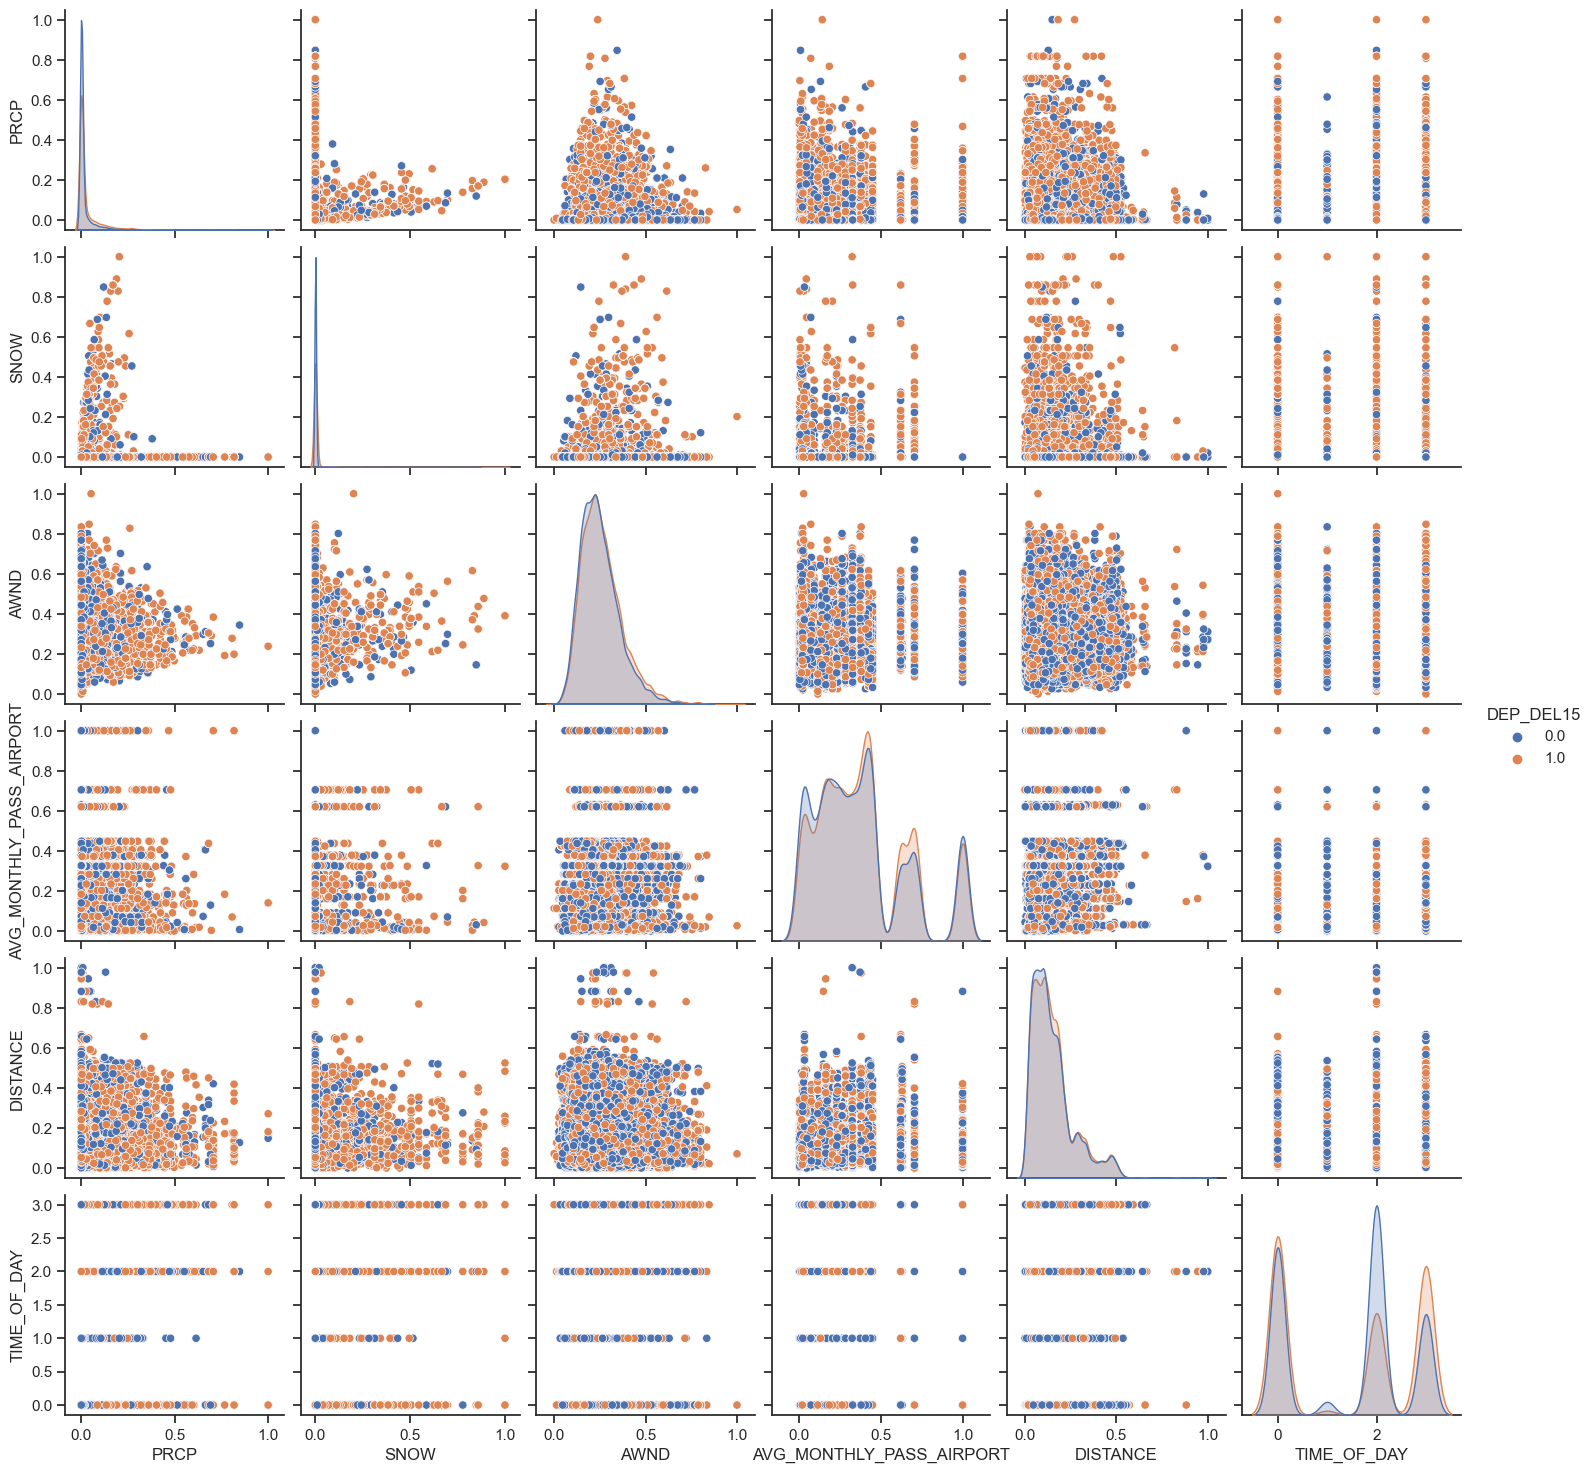

In [9]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(train_df, hue="DEP_DEL15")

### One-hot encoding

In [48]:
# one-hot encoding
ohe_enc = OneHotEncoder(categories='auto')
categorical_train = ohe_enc.fit_transform(final_train_df[selected_cat_var])
train_feature_names = ohe_enc.get_feature_names()

categorical_val = ohe_enc.fit_transform(final_valid_df[selected_cat_var])
val_feature_names = ohe_enc.get_feature_names()

categorical_test = ohe_enc.fit_transform(final_test_df[selected_cat_var])
test_feature_names = ohe_enc.get_feature_names()

X_train_encoded_df = pd.DataFrame(categorical_train.toarray())
X_val_encoded_df = pd.DataFrame(categorical_val.toarray())
X_test_encoded_df = pd.DataFrame(categorical_test.toarray())

In [49]:
X_train_encoded_df

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
55995,0.0,0.0,1.0,0.0
55996,0.0,0.0,1.0,0.0
55997,0.0,0.0,1.0,0.0
55998,0.0,0.0,1.0,0.0


In [50]:
print(train_feature_names)
print(val_feature_names)
print(test_feature_names)

print("\n")

for item in train_feature_names:
    if item not in val_feature_names:
        print("present in train but absent in val:", item)

    if item not in test_feature_names:
        print("present in train but absent in test:", item)

print("\n")

for item in val_feature_names:
    if item not in train_feature_names:
        print("present in val but absent in train:", item)

    if item not in test_feature_names:
        print("present in val but absent in test:", item)

print("\n")

for item in test_feature_names:
    if item not in train_feature_names:
        print("present in test but absent in train:", item)

    if item not in val_feature_names:
        print("present in test but absent in val:", item)

print("\n")

# print("Train needs: x1_30")
# print("Val needs: x1_38")
# print("Test needs: x1_30, x1_43")

# print("\n")
# # selected_cat_var = ["CARRIER_NAME", "DEPARTING_AIRPORT", "SEASON", "TIME_OF_DAY"]
# carrier_name_list = new_col_names[:16]
# departing_airport_list = new_col_names[16:79]
# season_list = new_col_names[79:83]
# time_of_day_list = new_col_names[86:90]
# selected_cat_col_names = carrier_name_list + departing_airport_list + season_list + time_of_day_list

['x0_0' 'x0_1' 'x0_2' 'x0_3']
['x0_0' 'x0_1' 'x0_2' 'x0_3']
['x0_0' 'x0_1' 'x0_2' 'x0_3']










In [52]:
# train
# zero_col = []
# for num in range(len(X_train_encoded_df.index)):
#     zero_col.append(0)

# left_split_list = list(range(46))
# right_split_list = list(range(46, len(X_train_encoded_df.columns)))

# X_train_left_split = X_train_encoded_df[left_split_list]
# X_train_left_split[46] = zero_col

# X_train_right_split = X_train_encoded_df[right_split_list]

# X_train_encoded_df = pd.DataFrame(np.hstack(
#     (X_train[selected_numeric_var],
#     X_train_left_split,
#     X_train_right_split)
# ))


In [53]:
# val
# zero_col = []
# for num in range(len(X_val_encoded_df.index)):
#     zero_col.append(0)

# left_split_list = list(range(54))
# right_split_list = list(range(54, len(X_val_encoded_df.columns)))

# X_val_left_split = X_val_encoded_df[left_split_list]
# X_val_left_split[54] = zero_col

# X_val_right_split = X_val_encoded_df[right_split_list]

# X_val_encoded_df = pd.DataFrame(np.hstack(
#     (X_valid[selected_numeric_var],
#     X_val_left_split,
#     X_val_right_split)
# ))

In [54]:
# test
# zero_col = []
# for num in range(len(X_test_encoded_df.index)):
#     zero_col.append(0)

# left_split_list = list(range(46))
# mid_split_list = list(range(46, 58))
# right_split_list = list(range(58, len(X_test_encoded_df.columns)))

# X_test_left_split = X_test_encoded_df[left_split_list]
# X_test_left_split[46] = zero_col

# X_test_mid_split = X_test_encoded_df[mid_split_list]
# X_test_mid_split[58] = zero_col

# X_test_right_split = X_test_encoded_df[right_split_list]

# X_test_encoded_df = pd.DataFrame(np.hstack(
#     (X_test[selected_numeric_var],
#     X_test_left_split,
#     X_test_mid_split,
#     X_test_right_split)
# ))

In [51]:
X_train_encoded_df = pd.DataFrame(np.hstack((X_train[selected_numeric_var], categorical_train.toarray())))
X_val_encoded_df = pd.DataFrame(np.hstack((X_valid[selected_numeric_var], categorical_val.toarray())))
X_test_encoded_df = pd.DataFrame(np.hstack((X_test[selected_numeric_var], categorical_test.toarray())))

In [52]:
selected_cat_col_names = new_col_names[7:]
selected_feature_names = selected_numeric_var + selected_cat_col_names

feature_names_dict = {}
for num in range(len(selected_feature_names)):
    feature_names_dict[num] = selected_feature_names[num]

for df in [X_train_encoded_df, X_val_encoded_df, X_test_encoded_df]:
    df.rename(columns=feature_names_dict, inplace=True)

In [53]:
X_train_encoded_df

,PRCP,SNOW,AWND,AVG_MONTHLY_PASS_AIRPORT,DISTANCE,Afternoon,Early Morning,Morning,Night
0,0.008386,0.0,0.245115,0.620588,0.085123,1.0,0.0,0.0,0.0
1,0.002096,0.0,0.456779,1.000000,0.239061,0.0,0.0,1.0,0.0
2,0.010482,0.0,0.225281,0.437569,0.012331,0.0,0.0,0.0,1.0
3,0.037736,0.0,0.278271,0.704801,0.287788,1.0,0.0,0.0,0.0
4,0.039832,0.0,0.211960,0.378600,0.184964,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
55995,0.000000,0.0,0.251628,1.000000,0.132060,0.0,0.0,1.0,0.0
55996,0.000000,0.0,0.483422,0.013036,0.241647,0.0,0.0,1.0,0.0
55997,0.000000,0.0,0.337774,0.620588,0.283214,0.0,0.0,1.0,0.0
55998,0.027254,0.0,0.145648,0.234743,0.044153,0.0,0.0,1.0,0.0


In [54]:
X_test_encoded_df

,PRCP,SNOW,AWND,AVG_MONTHLY_PASS_AIRPORT,DISTANCE,Afternoon,Early Morning,Morning,Night
0,0.044025,0.0,0.192126,0.437569,0.206842,1.0,0.0,0.0,0.0
1,0.000000,0.0,0.291297,0.405367,0.152546,0.0,0.0,1.0,0.0
2,0.094340,0.0,0.198638,0.129386,0.148568,1.0,0.0,0.0,0.0
3,0.000000,0.0,0.284784,0.704801,0.110183,0.0,0.0,1.0,0.0
4,0.000000,0.0,0.211960,0.378600,0.190135,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
11995,0.000000,0.0,0.423919,0.620588,0.144590,1.0,0.0,0.0,0.0
11996,0.000000,0.0,0.225281,0.620588,0.294153,0.0,0.0,1.0,0.0
11997,0.000000,0.0,0.317940,0.090802,0.178998,0.0,0.0,1.0,0.0
11998,0.000000,0.0,0.205151,0.170729,0.218775,0.0,0.0,0.0,1.0


In [55]:
X_val_encoded_df

,PRCP,SNOW,AWND,AVG_MONTHLY_PASS_AIRPORT,DISTANCE,Afternoon,Early Morning,Morning,Night
0,0.000000,0.0,0.152161,0.448310,0.060263,1.0,0.0,0.0,0.0
1,0.165618,0.0,0.337774,0.704801,0.159109,1.0,0.0,0.0,0.0
2,0.000000,0.0,0.238307,0.170729,0.112371,1.0,0.0,0.0,0.0
3,0.000000,0.0,0.105980,0.161507,0.103620,1.0,0.0,0.0,0.0
4,0.008386,0.0,0.105980,0.437569,0.190334,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
11995,0.033543,0.0,0.430432,0.161507,0.068815,1.0,0.0,0.0,0.0
11996,0.000000,0.0,0.072824,0.113038,0.108393,0.0,0.0,0.0,1.0
11997,0.000000,0.0,0.225281,0.372129,0.046539,0.0,0.0,1.0,0.0
11998,0.000000,0.0,0.218472,1.000000,0.119133,0.0,0.0,1.0,0.0


In [56]:
X_train_encoded_df.to_excel("X_train_encoded.xlsx", index=False)
y_train.to_excel("Y_train.xlsx", index=False)

X_val_encoded_df.to_excel("X_val_encoded.xlsx", index=False)
y_valid.to_excel("Y_val.xlsx", index=False)

X_test_encoded_df.to_excel("X_test_encoded.xlsx", index=False)
y_test.to_excel("Y_test.xlsx", index=False)